In [16]:
import matplotlib.pyplot as plt

import numpy as np

from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 

from torch.distributions.multivariate_normal import MultivariateNormal 

In [106]:
num_data = 3
x = np.arange(1, 1+num_data).reshape(num_data, 1)
xx = np.matmul(x, x.T)
print(xx)
tmp = np.diag(xx)[:,None]
print(tmp.shape)
rx = np.repeat(np.diag(xx)[None,:], num_data, axis=0)
print(rx)
x = torch.arange(1, 1+num_data).reshape(num_data, 1)
xx = torch.matmul(x, x.T)
rx = xx.diag().unsqueeze(0).expand_as(xx)
print(rx)

[[1 2 3]
 [2 4 6]
 [3 6 9]]
(3, 1)
[[1 4 9]
 [1 4 9]
 [1 4 9]]
tensor([[1, 4, 9],
        [1, 4, 9],
        [1, 4, 9]])


In [94]:
def MMD_RBF(x, y):
    num_data, num_feats = x.shape
    
    xx = torch.matmul(x, x.T)
    yy = torch.matmul(y, y.T)
    xy = torch.matmul(x, y.T)
    
    rx = xx.diag().unsqueeze(0).expand_as(xx)
    ry = yy.diag().unsqueeze(0).expand_as(yy)
    
    dxx = rx.T + rx - 2*xx
    dyy = ry.T + ry - 2*yy
    dxy = rx.T + ry - 2*xy
    
    kxx = torch.zeros(xx.shape)
    kyy = torch.zeros(yy.shape)
    kxy = torch.zeros(xy.shape)
    
    bandwidths = [10, 15, 20, 50]
    for bw in bandwidths:
        kxx += torch.exp(-alpha*dxx/bw)
        kyy += torch.exp(-alpha*dyy/bw)
        kxy += torch.exp(-alpha*dxy/bw)

    mn = 1./(num_data*(num_data-1)*len(bandwidths))
    mm = 2./(num_data*num_data*len(bandwidths))
    score = mn*torch.sum(kxx) - mm*torch.sum(kxy) + mn*torch.sum(kyy)

    return score

num_data = 1000
x_mean = torch.zeros(2)
y_mean = torch.zeros(2)+20
x_cov = 2*torch.eye(2)
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([num_data])
y = qy.sample([num_data])

# print(x)
# print(y)
    
mmd_score = MMD_RBF(x, y)
print(mmd_score)

tensor(1.6311)


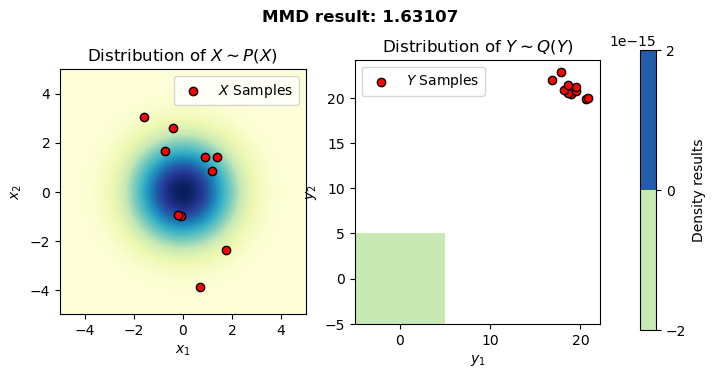

In [95]:
# Plotting
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=num_data)
x2_val = np.linspace(-5, 5, num=num_data)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(num_data, num_data)
qy_grid = torch.zeros(num_data, num_data)

for i in range(num_data):
    for j in range(num_data):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i], x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i], x2_val[j]], y_mean, y_cov)

CS1 = ax1.contourf(x1, x2, px_grid, 100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid, 100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {mmd_score.item():0.5f}",y=0.95, fontweight="bold")
plt.show()